Objective: forecast stock price index according to its historical values.

Import necessary modules first

In [5]:
from pandas import Series,DataFrame
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Read data from csv

In [6]:
stock = pd.read_csv('spx.csv',header=0,index_col=0,parse_dates=True)

Plot line graph for the series and see if there is any trend, 
we need to make it stationary before building a model for forecasting

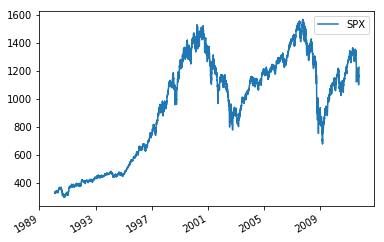

In [7]:
stock.plot()

The pic shows a trend in the series, we can double check by performing ADF test for stationarity.
If the p value for ADF test is smaller than 0.05, it means the series is stationary (no trend).

In [8]:
from statsmodels.tsa.stattools import adfuller as ADF
p_value = ADF(stock['SPX'])[1]
if p_value < 0.05:
    print('The series is stationary')
else:
    print('The series is not stationary')

The series is not stationary


The output confirmed the stock price series is not stationary, we need to remove the trend by 
differencing the series until it is stationary (the difference of current values and previous values)

In [9]:
diff = 0
adf = ADF(stock['SPX'])
while adf[1] > 0.05:
    diff = diff + 1
    adf = ADF(stock['SPX'].diff(diff).dropna())
print('After differencing for {} time(s), the series is now stationary, p_value is {}'.format(diff,p_value))


After differencing for 1 time(s), the series is now stationary, p_value is 0.5037180736830396


We will then check the differenced series is white noise or not by performing diagnostic test.
If the p value is smaller than 0.05, it means the series is not white noise.

In [10]:
from statsmodels.stats.diagnostic import acorr_ljungbox
stock_diff = stock['SPX'].diff(1).dropna()
p_value = acorr_ljungbox(stock_diff, lags=1)[1][0]
if p_value<0.05:
    print('The differenced series is not white noise')
else:
    print('The differenced series is white noise')

The differenced series is not white noise


Confirmed the differenced series is not white noise, we can use it to build an ARIMA (p,d,q) model. 
Parameter ‘d’ in the model is already confirmed as 1 as we differenced 1 time. 
Next we will confirm ‘p’ and ‘q’. To do this, we can look at the autocorrelation plot (acf)
and partial-autocorrelation plot (pacf)

Text(0.5,1,'Autocorrelation')

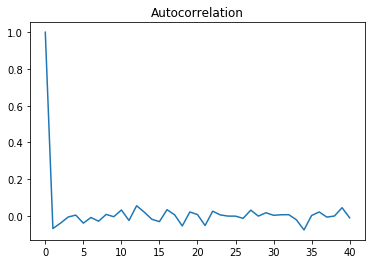

In [18]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(stock_diff)
lag_pacf = pacf(stock_diff)
Series(lag_acf).plot()
plt.title('Autocorrelation')

Text(0.5,1,'Partial-Autocorrelation')

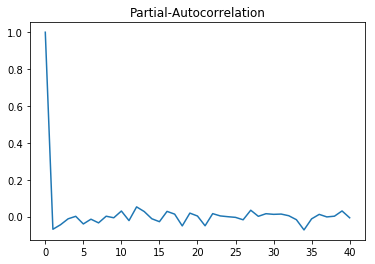

In [19]:
Series(lag_pacf).plot()
plt.title('Partial-Autocorrelation')

But to be more accurate, we will look for the smallest BIC values in the ARIMA models 
for different combinations of p and q to determine the best parameters (we will test for 
p = 0 to 3 and q = 0 to 3 as the acf and pacf graphs suggest that p and q values should be around 1
as acf and pacf drop to 0 in y axis at 1 in x axis

In [37]:
from statsmodels.tsa.arima_model import ARIMA
pmax = 3
qmax = 3
bic_matrix = []
for p in range(pmax+1):
    tmp = []
    for q in range(qmax+1):
        try:
            tmp.append(ARIMA(stock['SPX'].values, (p,1,q)).fit(disp=0).bic)
        except:
            tmp.append(None)
    bic_matrix.append(tmp)
bic_matrix = pd.DataFrame(bic_matrix)
p,q = bic_matrix.stack().idxmin() # get the p and q values for the smallest BIC value
print('Best p and q parameter values are: {}, {}' .format(p,q))

C:\Users\fungleung\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\fungleung\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\fungleung\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interprete

Best p and q parameter values are: 1, 1


The best p and q are both 1 for the model, so the model we will use for predicting is ARIMA (1,1,1)

In [36]:
model = ARIMA(stock['SPX'].values, (p,1,q)).fit(disp=0)

Then we will test the residual of the ARIMA model if they are white noise using ADF test again

In [28]:
residuals = DataFrame(model.resid)
p_value = acorr_ljungbox(residuals, lags = 1)[1]
if p_value < 0.05:
    print('The residuals are not white noise, model is NOT GOOD for use')
else:
    print('The residuals are white noise, model is good for use')

The residuals are white noise, model is good for use


The output shows that the ARIMA model is good for forecasting future data now

In [29]:
model.forecast(5)[0]

array([1222.55001842, 1221.44474456, 1220.87420967, 1220.61290307,
       1220.53041666])

We forecasted the future 5 days data for SPX stock price index. To evaluate the 
performance of the model, we can split the series into training and testing data 
set (e.g. last 10 observations as testing dataset and the rest as training data 
set for model training), then use the fitted model to predict the last 10 observations
and compare with the real data in testing dataset by root mean squared error or other metrics

In [40]:
from sklearn import metrics
stock_train = stock['SPX'][:-10].values
stock_test = stock['SPX'][-10:].values
model = ARIMA(stock_train, (p,1,q)).fit(disp=0)
predictions = model.forecast(10)[0]
MSE = metrics.mean_squared_error(stock_test, predictions)
print("Root Mean Squared Error is {:.2f}".format(np.sqrt(MSE)))

Root Mean Squared Error is 51.09


Print out the actual stock price index values (stock_test) and the predicted values for the last 10 days

In [43]:
print('Actual SPX stock index: \n{}\n'.format(stock_test))
print('Predicted SPX stock index: \n{}'.format(predictions))

Actual SPX stock index: 
[1099.23 1123.95 1144.03 1164.97 1155.46 1194.89 1195.54 1207.25 1203.66
 1224.58]

Predicted SPX stock index: 
[1133.63342685 1134.96529929 1135.79184021 1136.32871104 1136.69953493
 1136.97517608 1137.19625584 1137.38605949 1137.55793481 1137.71953311]
